<a href="https://colab.research.google.com/github/DonJM/FCLB-TFOD/blob/master/FCLB_TFOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install Modules and Libraries

In [3]:
!pip install wget

#import neccessary python modules and libraries
import os
import shutil
from PIL import ImageEnhance
from PIL import Image
import uuid
import tarfile
import wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=aa80c116411cec063792af70d76dd548ff22b24ba95cd78fa1e767fb8d26cec4
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# Adding Classes for Path Setup and Project Dataset

In [25]:
class Setup_Path: 

    LABELS = ["fresh", "rotten"]

    def getFiles(self):
      files = {
          "LABELMAP":os.path.join(self.getWorkspaces()['ANNOTATIONS_PATH'], "label_map.pbtxt"),
          'TFRECORD_SCRIPT':os.path.join(self.getWorkspaces()['PREPROCESSING_PATH'], 'generate_tfrecord.py'),
          "PRETRAINED_MODEL_NAME": 'efficientdet_d1_coco17_tpu-32',
          "PRETRAINED_MODEL_URL": 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz', 
          #"PRETRAINED_MODEL_URL": 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz', 
          "PIPELINE_CONFIG": os.path.join("Tensorflow", "workspace", "training_demo", "my_ssd_mobnet", "pipeline.config")
      }

      return files

    def getWorkspaces(self):
        paths = {
            "ADDONS_PATH":os.path.join("Tensorflow", "addons"),
            "LABEL_IMG_PATH":os.path.join("Tensorflow", "addons", "labelImg"),
            "TFOD_API_PATH":"Tensorflow",
            "WORKSPACE_PATH":os.path.join("Tensorflow", "workspace"),
            "TRAINING_DEMO_PATH":os.path.join("Tensorflow", "workspace", "training_demo"),
            "ANNOTATIONS_PATH":os.path.join("Tensorflow", "workspace", "training_demo", "annotations"),
            "IMAGES_PATH":os.path.join("Tensorflow", "workspace", "training_demo", "images"),
            "TRAINING_IMAGES_PATH":os.path.join("Tensorflow", "workspace", "training_demo", "images", "train"),
            "TESTING_IMAGES_PATH":os.path.join("Tensorflow", "workspace", "training_demo", "images", "test"),
            "PRETRAINED_MODELS_PATH":os.path.join("Tensorflow", "workspace", "training_demo", "pre-trained-models"),
            "PREPROCESSED_IMG":os.path.join("Tensorflow", "addons", "preprocessedImg"),
            "ORIGINAL_IMGS":os.path.join("Tensorflow", "addons", "originalImg"),   
            "PREPROCESSING_PATH":os.path.join("Tensorflow", "scripts", "preprocessing"),
            "PROTOS_PATH":os.path.join("Tensorflow", "Google-Protobuf"),
            'CHECKPOINT_PATH': os.path.join("Tensorflow", "workspace", "training_demo", 'my_ssd_mobnet'),
            'TFJS_PATH':os.path.join('Tensorflow', 'workspace', "training_demo",'my_ssd_mobnet', 'tfjsexport'), 
            'TFLITE_PATH':os.path.join('Tensorflow', 'workspace', "training_demo",'my_ssd_mobnet', 'tfliteexport'),
            'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace',"training_demo",'my_ssd_mobnet', 'export'), 
        }

        return paths

    # def set_main_paths(self):
    #     for path in self.get_main_paths().values():
    #         if not os.path.exists(path):
    #             os.makedirs(path)

    # def get_image_paths(self):
    #     path = {
    #         "ORIGINAL_IMAGES_PATH" : ["workspace\datasets\original_images\Fresh_Ripe", "workspace\datasets\original_images\Fresh_Unripe", "workspace\datasets\original_images\Rotten_Ripe", "workspace\datasets\original_images\Rotten_Unripe"],
    #         "PREPROCESSED_IMAGES_PATH" : ["workspace\datasets\preprocessed_images\Fresh_Ripe", "workspace\datasets\preprocessed_images\Fresh_Unripe", "workspace\datasets\preprocessed_images\Rotten_Ripe", "workspace\datasets\preprocessed_images\Rotten_Unripe"],
    #     }

    #     return path

    # def set_image_paths(self):
    #     for path in self.get_image_paths().values():
    #         for label in path:
    #             if not os.path.exists(label):
    #                 os.makedirs(label)

    # def getFiles(self):
    #     files = {
    #         'PIPELINE_CONFIG':os.path.join(self.get_paths()['MODELS_PATH'], self.custom_name, 'pipeline.config'),
    #         'TF_RECORD_SCRIPT':os.path.join(self.get_paths()['TFRECORD_GENERATOR_PATH'], self.tfrecord_name),
    #         'LABEL_MAP':os.path.join(self.get_paths()['ANOTATIONS_PATH'], self.map_name),
    #     }
    #     return files

In [5]:
class FCLB_Datasets:
    #class' constructor
    def __init__(self, setup):
        self.setup = setup
    
    #acquiring uncategorized dataset
    def get_original_dataset(self, num1, num2, label):
        images_path = self.setup.getWorkspaces()['ORIGINAL_IMGS']
        path = os.path.join(images_path, label)

        files = ["{}".format(i) for i in os.listdir(path)[num1:num2]]

        return files

    def copy_image_file(self, num1, num2, srcPath, dstPath):

        for label in self.setup.LABELS:
            for file in self.get_original_dataset(num1, num2, label):
                dst = os.path.join(dstPath, label, file)
                src = os.path.join(srcPath, label, file)
                shutil.copyfile(src, dst)

    #I call it segment function, wala na koy mahunahunaan
    def segment(self):
        original_dir = self.setup.getWorkspaces()['ORIGINAL_IMGS']
        target_dir = self.setup.getWorkspaces()['PREPROCESSED_IMG']
        labels = self.setup.LABELS

        for label in labels:
            original = os.path.join(original_dir, label)
            target = os.path.join(target_dir, label)
            for img in os.listdir(original):
                self.segmentation(original, target, img, label)
 

    #this function used to segment an image file, it actually resize image, add contrast and lightness
    #and save it to the target directory
    #the purpose of uuid module is to give unique id or name to an image file
    def segmentation(self, base_dir, target_dir, fname, label):
        image = Image.open(os.path.join(base_dir, fname))
        size = (320,320)
        image.thumbnail(size)

        n = random.randint(0,360)
        image = np.asarray(image)
        
        rotate=iaa.Affine(rotate=(-(n), n))
        rotated_image=rotate.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), rotated_image)
        
        
        gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
        noise_image=gaussian_noise.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), noise_image)
        
        
        crop = iaa.Crop(percent=(0, 0.3)) # crop image
        crop_image=crop.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), crop_image)
        
        
        shear = iaa.Affine(shear=(0,40))
        shear_image=shear.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), shear_image)
        
        
        #flipping image horizontally
        flip_hr=iaa.Fliplr(p=1.0)
        flip_hr_image= flip_hr.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), flip_hr_image)
        
        
        flip_vr=iaa.Flipud(p=1.0)
        flip_vr_image= flip_vr.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), flip_vr_image)
        
        
        contrast=iaa.GammaContrast(gamma=0.3)
        contrast_image =contrast.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), contrast_image)
        
        contrast=iaa.GammaContrast(gamma=0.9)
        contrast_image =contrast.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), contrast_image)
        
        
        scale_im=iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)})
        scale_image =scale_im.augment_image(image)
        imageio.imsave(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())), scale_image)
        
#         contrast = ImageEnhance.Contrast(image)
#         contrast.enhance(1.8).save(os.path.join(target_dir, label + "-"+ '{}.jpg'.format(uuid.uuid1())))
 
#         brightness = ImageEnhance.Brightness(image)
#         brightness.enhance(1.2).save(os.path.join(target_dir, label +"-"+ '{}.jpg'.format(uuid.uuid1())))

    #compressed file for github upload
    def compressed(self):
        path = self.getDir('PREPROCESSED_IMAGES_PATH')
        sub_paths = self.getSubDirectories(path)
        ARCHIVE_PATH = os.path.join(path, 'preprocessed_images.tar.gz')
        tar = tarfile.open(ARCHIVE_PATH, "w:gz")
        for sub_path in sub_paths:
            dir = os.path.join(path, sub_path)
            tar.add(dir)
        tar.close()

# Preparing Workspace

Creating a workspace directory

In [26]:
setup = Setup_Path()
workspaces = setup.getWorkspaces()
for workspace in workspaces.values():
  if not os.path.exists(workspace):
    os.makedirs(workspace)

In [ ]:
!unzip /content/train.zip
shutil.move('/content/fresh', setup.getWorkspaces()['ORIGINAL_IMGS'])
shutil.move('/content/rotten', setup.getWorkspaces()['ORIGINAL_IMGS'])

Archive:  /content/train.zip
replace fresh/Fresh.526.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fresh/Fresh.534.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace fresh/Fresh.534.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fresh/Fresh.534.jpg     
replace fresh/Fresh.718.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fresh/Fresh.718.jpg     
replace fresh/Fresh.729.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fresh/Fresh.729.jpg     
replace fresh/Fresh.743.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fresh/Fresh.743.jpg     
replace fresh/Fresh.799.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fresh/Fresh.799.jpg     
replace rotten/Rotten.120.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: rotten/Rotten.120.jpg   
replace rotten/Rotten.1538.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: rotten/Rotten.1538.jpg  
replace rotten/Rotten.1553.jpg? [y]es, [n]o, [A]ll

'Tensorflow/addons/originalImg/rotten'

Create label directory for original images and preprocessed images

In [ ]:
for label in setup.LABELS:
  preprocessedImg_labelPath = os.path.join(setup.getWorkspaces()['PREPROCESSED_IMG'], label)
  if not os.path.exists(preprocessedImg_labelPath):
    os.makedirs(preprocessedImg_labelPath)

segment images and copy to preprocessed directory

In [ ]:
dataset = FCLB_Datasets(setup)
dataset.segment()

In [ ]:
!cd /content/Tensorflow && zip {setup.getWorkspaces()['PREPROCESSED_IMG']}


zip error: Nothing to do! (Tensorflow/addons/preprocessedImg.zip)


# Image Labelling

In [ ]:
labelImg = setup.getWorkspaces()['LABEL_IMG_PATH']
!cd {labelImg} && git clone https://github.com/tzutalin/labelImg.git

Cloning into 'labelImg'...
remote: Enumerating objects: 1846, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1846 (delta 37), reused 55 (delta 18), pack-reused 1759
Receiving objects: 100% (1846/1846), 232.81 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (1084/1084), done.


In [ ]:
labelImg = os.path.join(setup.getWorkspaces()['LABEL_IMG_PATH'], "labelImg")
!cd {labelImg} && pip install pyqt5
!cd {labelImg} && pyrcc5 -o libs/resources.py resources.qrc

Compress of Image Labeling

In [ ]:
TRAIN_PATH = os.path.join(setup.getWorkspaces()['PREPROCESSED_IMG'], 'train')
TEST_PATH = os.path.join(setup.getWorkspaces()['PREPROCESSED_IMG'], 'test')
ARCHIVE_PATH = os.path.join(setup.getWorkspaces()['PREPROCESSED_IMG'], 'archive.tar.gz')

In [ ]:
!tar -czf {ARCHIVE_PATH} {TRAIN_PATH} {TEST_PATH}

tar: Tensorflow/addons/preprocessedImg/train: Cannot stat: No such file or directory
tar: Tensorflow/addons/preprocessedImg/test: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


# Partition Dataset

In [ ]:
url = "https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/d0e545609c5f7f49f39abc7b6a38cec3/partition_dataset.py"
src = wget.download(url)
dst = setup.getWorkspaces()['PREPROCESSING_PATH']
shutil.move(src, dst)

'Tensorflow/scripts/preprocessing/partition_dataset.py'

In [ ]:
images_path = setup.getWorkspaces()['IMAGES_PATH']
!cd {dst} python partition_dataset.py -x -i {images_path} -r 0.1

/bin/bash: line 0: cd: too many arguments


# Download Tensorflow Object Detection API

In [7]:
tfod_api = setup.getWorkspaces()['TFOD_API_PATH']
!cd {tfod_api} && git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 61644, done.
remote: Total 61644 (delta 0), reused 0 (delta 0), pack-reused 61644
Receiving objects: 100% (61644/61644), 574.22 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (42898/42898), done.


# Install Object Detection

In [8]:
research_path = os.path.join(setup.getWorkspaces()['TFOD_API_PATH'], 'models', 'research')
!cd {research_path} && cp object_detection/packages/tf2/setup.py setup.py

In [9]:
url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
src = wget.download(url)
protos_path = setup.getWorkspaces()['PROTOS_PATH']
shutil.move(src, protos_path)


'Tensorflow/Google-Protobuf/protoc-3.15.6-win64.zip'

In [10]:
!cd {protos_path} && unzip {src}

Archive:  protoc-3.15.6-win64.zip
   creating: include/
   creating: include/google/
   creating: include/google/protobuf/
  inflating: include/google/protobuf/wrappers.proto  
  inflating: include/google/protobuf/field_mask.proto  
  inflating: include/google/protobuf/api.proto  
  inflating: include/google/protobuf/struct.proto  
  inflating: include/google/protobuf/descriptor.proto  
  inflating: include/google/protobuf/timestamp.proto  
   creating: include/google/protobuf/compiler/
  inflating: include/google/protobuf/compiler/plugin.proto  
  inflating: include/google/protobuf/empty.proto  
  inflating: include/google/protobuf/any.proto  
  inflating: include/google/protobuf/source_context.proto  
  inflating: include/google/protobuf/type.proto  
  inflating: include/google/protobuf/duration.proto  
   creating: bin/
  inflating: bin/protoc.exe          
  inflating: readme.txt              


In [11]:
!apt-get install protobuf-compiler
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.8 MB 6.4 MB/s 
     |████████████████████████████████| 352 kB 35.6 MB/s 
     |████████████████████████████████| 1.8 MB 25.7 MB/s 
     |████████████████████████████████| 37.1 MB 37 kB/s 
     |████████████████████████████████| 1.1 MB 38.6 MB/s 
     |████████████████████████████████| 9

In [12]:
# !cd {research_path} && python object_detection/builders/model_builder_tf2_test.py
VERIFICATION_SCRIPT = os.path.join(research_path, 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2021-09-07 02:30:36.909223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 02:30:37.511102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 02:30:37.512012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Running tests under Python 3.7.11: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-09-07 02:30:37.533612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021

In [13]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
apache-beam                   2.32.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
avro-python3                  1.9.2.1
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca   

In [14]:
import object_detection

# Create Label Map

In [15]:
labels = [{'name':'FreshRipe', 'id':1}, {'name':'FreshUnripe', 'id':2}, {'name':'RottenRipe', 'id':3}, {'name':'RottenUnripe', 'id':4}]

with open(setup.getFiles()['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Create Tensorflow Records

In [28]:
!tar -zxvf /content/test_and_train.tar.gz

workspace/images/train/
workspace/images/train/Fresh.109.jpg
workspace/images/train/Fresh.109.xml
workspace/images/train/Fresh.110.jpg
workspace/images/train/Fresh.110.xml
workspace/images/train/Fresh.111.jpg
workspace/images/train/Fresh.111.xml
workspace/images/train/Fresh.112.jpg
workspace/images/train/Fresh.112.xml
workspace/images/train/Fresh.113.jpg
workspace/images/train/Fresh.113.xml
workspace/images/train/Fresh.114.jpg
workspace/images/train/Fresh.114.xml
workspace/images/train/Fresh.115.jpg
workspace/images/train/Fresh.115.xml
workspace/images/train/Fresh.116.jpg
workspace/images/train/Fresh.116.xml
workspace/images/train/Fresh.117.jpg
workspace/images/train/Fresh.117.xml
workspace/images/train/Fresh.118.jpg
workspace/images/train/Fresh.118.xml
workspace/images/train/Fresh.119.jpg
workspace/images/train/Fresh.119.xml
workspace/images/train/Fresh.120.jpg
workspace/images/train/Fresh.120.xml
workspace/images/train/Fresh.121.jpg
workspace/images/train/Fresh.121.xml
workspace/imag

In [ ]:
rootPath = setup.getWorkspaces()['LABEL_IMG_PATH']
paths = os.listdir(rootPath)

for path in paths:
  imagePaths = os.path.join(rootPath, path)
  for labelPath in os.listdir(imagePaths):
    labelPaths = os.path.join(imagePaths,labelPath)
    for img in os.listdir(labelPaths):
      imgPath = os.path.join(labelPaths, img)
      if 'train' in imgPath:
        shutil.move(imgPath, setup.getWorkspaces()['TRAINING_IMAGES_PATH'])
      if 'test' in imgPath:
        shutil.move(imgPath, setup.getWorkspaces()['TESTING_IMAGES_PATH'])


In [41]:
url = 'https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py'
src = wget.download(url)
dst = setup.getWorkspaces()['PREPROCESSING_PATH']
shutil.move(src, dst)

'Tensorflow/scripts/preprocessing/generate_tfrecord.py'

In [42]:
# Create train data:
!python {setup.getFiles()['TFRECORD_SCRIPT']} -x {setup.getWorkspaces()['TRAINING_IMAGES_PATH']} -l {setup.getFiles()['LABELMAP']} -o {os.path.join(setup.getWorkspaces()['ANNOTATIONS_PATH'], 'train.record')}

# Create test data:
!python {setup.getFiles()['TFRECORD_SCRIPT']} -x {setup.getWorkspaces()['TESTING_IMAGES_PATH']} -l {setup.getFiles()['LABELMAP']} -o {os.path.join(setup.getWorkspaces()['ANNOTATIONS_PATH'], 'test.record')}

Successfully created the TFRecord file: Tensorflow/workspace/training_demo/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/training_demo/annotations/test.record


# Download Pretrained Model

In [24]:
pretrained_mode_file = wget.download(setup.getFiles()['PRETRAINED_MODEL_URL'])
shutil.move(pretrained_mode_file, setup.getWorkspaces()['PRETRAINED_MODELS_PATH'])
!cd {setup.getWorkspaces()['PRETRAINED_MODELS_PATH']} && tar -zxvf {pretrained_mode_file}

efficientdet_d1_coco17_tpu-32/
efficientdet_d1_coco17_tpu-32/checkpoint/
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d1_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d1_coco17_tpu-32/pipeline.config
efficientdet_d1_coco17_tpu-32/saved_model/
efficientdet_d1_coco17_tpu-32/saved_model/saved_model.pb
efficientdet_d1_coco17_tpu-32/saved_model/assets/
efficientdet_d1_coco17_tpu-32/saved_model/variables/
efficientdet_d1_coco17_tpu-32/saved_model/variables/variables.data-00000-of-00001
efficientdet_d1_coco17_tpu-32/saved_model/variables/variables.index


In [27]:
setup.getWorkspaces()['PRETRAINED_MODELS_PATH']

'Tensorflow/workspace/training_demo/pre-trained-models'

# Make your own copy of pre-trained model

In [30]:
!cp {os.path.join(setup.getWorkspaces()['PRETRAINED_MODELS_PATH'], 'efficientdet_d1_coco17_tpu-32', 'pipeline.config')} {os.path.join(setup.getWorkspaces()['CHECKPOINT_PATH'])}

In [31]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [32]:
config = config_util.get_configs_from_pipeline_file(setup.getFiles()['PIPELINE_CONFIG'])

In [33]:
setup.getFiles()['PIPELINE_CONFIG']

'Tensorflow/workspace/training_demo/my_ssd_mobnet/pipeline.config'

In [34]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false
 batch_size: 1,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 640
       max_dimension: 640
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b1_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           st

In [35]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(setup.getFiles()['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [39]:
pipeline_config.model.ssd.num_classes = 4
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(setup.getWorkspaces()['PRETRAINED_MODELS_PATH'], 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8', 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= setup.getFiles()['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(setup.getWorkspaces()['ANNOTATIONS_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = setup.getFiles()['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(setup.getWorkspaces()['ANNOTATIONS_PATH'], 'test.record')]

In [40]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(setup.getFiles()['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Model Training

In [43]:
TRAINING_SCRIPT = os.path.join(setup.getWorkspaces()['TFOD_API_PATH'], 'models', 'research', 'object_detection', 'model_main_tf2.py')

In [44]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, setup.getWorkspaces()['CHECKPOINT_PATH'],setup.getFiles()['PIPELINE_CONFIG'])

In [45]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/training_demo/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/training_demo/my_ssd_mobnet/pipeline.config --num_train_steps=2000


In [46]:
!{command}

2021-09-07 02:42:56.753271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 02:42:56.767869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 02:42:56.768657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 02:42:56.770202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 02:42:56.770996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

# Model Evaluation

In [33]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, setup.getWorkspaces()['CHECKPOINT_PATH'], setup.getFiles()['PIPELINE_CONFIG'], setup.getWorkspaces()['CHECKPOINT_PATH'])

In [34]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/training_demo/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/training_demo/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/training_demo/my_ssd_mobnet


In [35]:
!{command}

2021-09-07 01:53:18.785269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 01:53:18.794184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 01:53:18.794965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
W0907 01:53:18.800065 140656802068352 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0907 01:53:18.800385 140656802068352 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat

## Load Train Model From Checkpoint

In [42]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [63]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(setup.getFiles()['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(setup.getWorkspaces()['CHECKPOINT_PATH'], 'ckpt-1')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## Detect from Image

In [64]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [65]:
category_index = label_map_util.create_category_index_from_labelmap(setup.getFiles()['LABELMAP'])

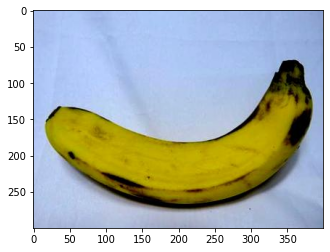

In [85]:
IMAGE_PATH = os.path.join(setup.getWorkspaces()['IMAGES_PATH'], 'test', 'Fresh.5.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=0.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [76]:
detections['detection_scores'] * 10

array([0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951803,
       0.09951803, 0.09951803, 0.09951803, 0.09951803, 0.09951

# Graph Freezing

In [58]:
FREEZE_SCRIPT = os.path.join(setup.getWorkspaces()['TFOD_API_PATH'], 'models', 'research', 'object_detection', 'exporter_main_v2.py')

In [59]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,setup.getFiles()['PIPELINE_CONFIG'], setup.getWorkspaces()['CHECKPOINT_PATH'], setup.getWorkspaces()['OUTPUT_PATH'])

In [60]:
print(command)

python Tensorflow/models/research/object_detection/exporter_main_v2.py --input_type=image_tensor --pipeline_config_path=Tensorflow/workspace/training_demo/my_ssd_mobnet/pipeline.config --trained_checkpoint_dir=Tensorflow/workspace/training_demo/my_ssd_mobnet --output_directory=Tensorflow/workspace/training_demo/my_ssd_mobnet/export


In [61]:
!{command}

2021-09-07 01:57:23.069431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 01:57:23.079250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 01:57:23.080039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 01:57:23.089814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-07 01:57:23.090555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

# Tensorflow Javascript (TFJS) Conversion

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 1.9 MB/s 


In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(setup.getWorkspaces()['OUTPUT_PATH'], 'saved_model'), setup.getWorkspaces()['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# TF Lite Conversion

In [ ]:
TFLITE_SCRIPT = os.path.join(setup.getWorkspaces()['TFOD_API_PATH'], 'models', 'research', 'object_detection', 'export_tflite_graph_tf2.py')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,setup.getFiles()['PIPELINE_CONFIG'], setup.getWorkspaces()['CHECKPOINT_PATH'], setup.getWorkspaces()['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# ZIP and Export Models

In [ ]:
!tar -czf models.tar.gz {setup.getWorkspaces()['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')